In [26]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

# LOAD DATA

In [27]:
# 1. Cargar el JSON (suponiendo que el archivo se llama 'fulldata.json')
with open('jsonclean/fulldata.json', 'r') as f:
    data = json.load(f)

# TRANSFORM TIME

In [30]:
# 2. Convertir cada key en un DataFrame (las keys son los nombres de las variables)
# Cada variable tiene un diccionario de {timestamp: valor}. Convertiremos los timestamps.
def dict_to_df(d):
    # Convertir el diccionario a DataFrame y convertir la columna de índices (timestamps)
    df = pd.DataFrame(list(d.items()), columns=['timestamp', 'value'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

# DATAFRAMES PARA CADA VARIABLE

In [49]:
# Create DataFrames for investment variables
df_cine         = dict_to_df(data["CINE"])
df_exterior     = dict_to_df(data["EXTERIOR"])
df_internet     = dict_to_df(data["INTERNET"])
df_prensa       = dict_to_df(data["PRENSA"])
df_produccion   = dict_to_df(data["PRODUCCION"])
df_radio        = dict_to_df(data["RADIO"])
df_revistas     = dict_to_df(data["REVISTAS"])
df_plataformas  = dict_to_df(data["PlataformasVideo"])
df_varios       = dict_to_df(data["VARIOS"])

# Create DataFrames for outcomes
df_visit_store = dict_to_df(data["Visit_Store"])
df_sales       = dict_to_df(data["Sales"])
df_unique      = dict_to_df(data["Unique_visitors"])


/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_97739/1952497552.py:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_97739/1952497552.py:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_97739/1952497552.py:6: FutureWarning: The behavio

In [40]:

# ---------------------------
# 2. Group Investments into Four Channels
# ---------------------------
# Group "Otros" as the sum of EXTERIOR, PRENSA, RADIO, REVISTAS, PRODUCCION, VARIOS
dfs_otros = [
    df_exterior.rename(columns={'value': 'EXTERIOR'}),
    df_prensa.rename(columns={'value': 'PRENSA'}),
    df_radio.rename(columns={'value': 'RADIO'}),
    df_revistas.rename(columns={'value': 'REVISTAS'}),
    df_produccion.rename(columns={'value': 'PRODUCCION'}),
    df_varios.rename(columns={'value': 'VARIOS'})
]
df_otros = pd.concat(dfs_otros, axis=1).fillna(0)
df_otros['Otros'] = df_otros.sum(axis=1)

# Resample each series to monthly (using sum)
df_internet_m    = df_internet.resample('M').sum().rename(columns={'value': 'Internet'})
df_plataformas_m = df_plataformas.resample('M').sum().rename(columns={'value': 'Plataformas'})
df_cine_m        = df_cine.resample('M').sum().rename(columns={'value': 'Cine'})
df_otros_m       = df_otros.resample('M').sum()[['Otros']]

# Merge the four groups into one DataFrame of predictors
df_inv = pd.concat([df_internet_m, df_plataformas_m, df_cine_m, df_otros_m], axis=1)
print("Grouped Investment Data (monthly):")
print(df_inv.head())

Grouped Investment Data (monthly):
             Internet  Plataformas      Cine      Otros
timestamp                                              
2022-01-31  133666.43    338824.94  59887.84   42220.93
2022-02-28  189275.94    487537.14  72291.56  167410.44
2022-03-31  214037.62     75000.00  55000.00   23484.85
2022-04-30  194816.97    610865.89  10883.30  124621.75
2022-05-31  130795.16    393807.74  74333.20  147454.07


/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_97739/4035420206.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_internet_m    = df_internet.resample('M').sum().rename(columns={'value': 'Internet'})
/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_97739/4035420206.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_plataformas_m = df_plataformas.resample('M').sum().rename(columns={'value': 'Plataformas'})
/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_97739/4035420206.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_cine_m        = df_cine.resample('M').sum().rename(columns={'value': 'Cine'})
/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_97739/4035420206.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
 

<Axes: >

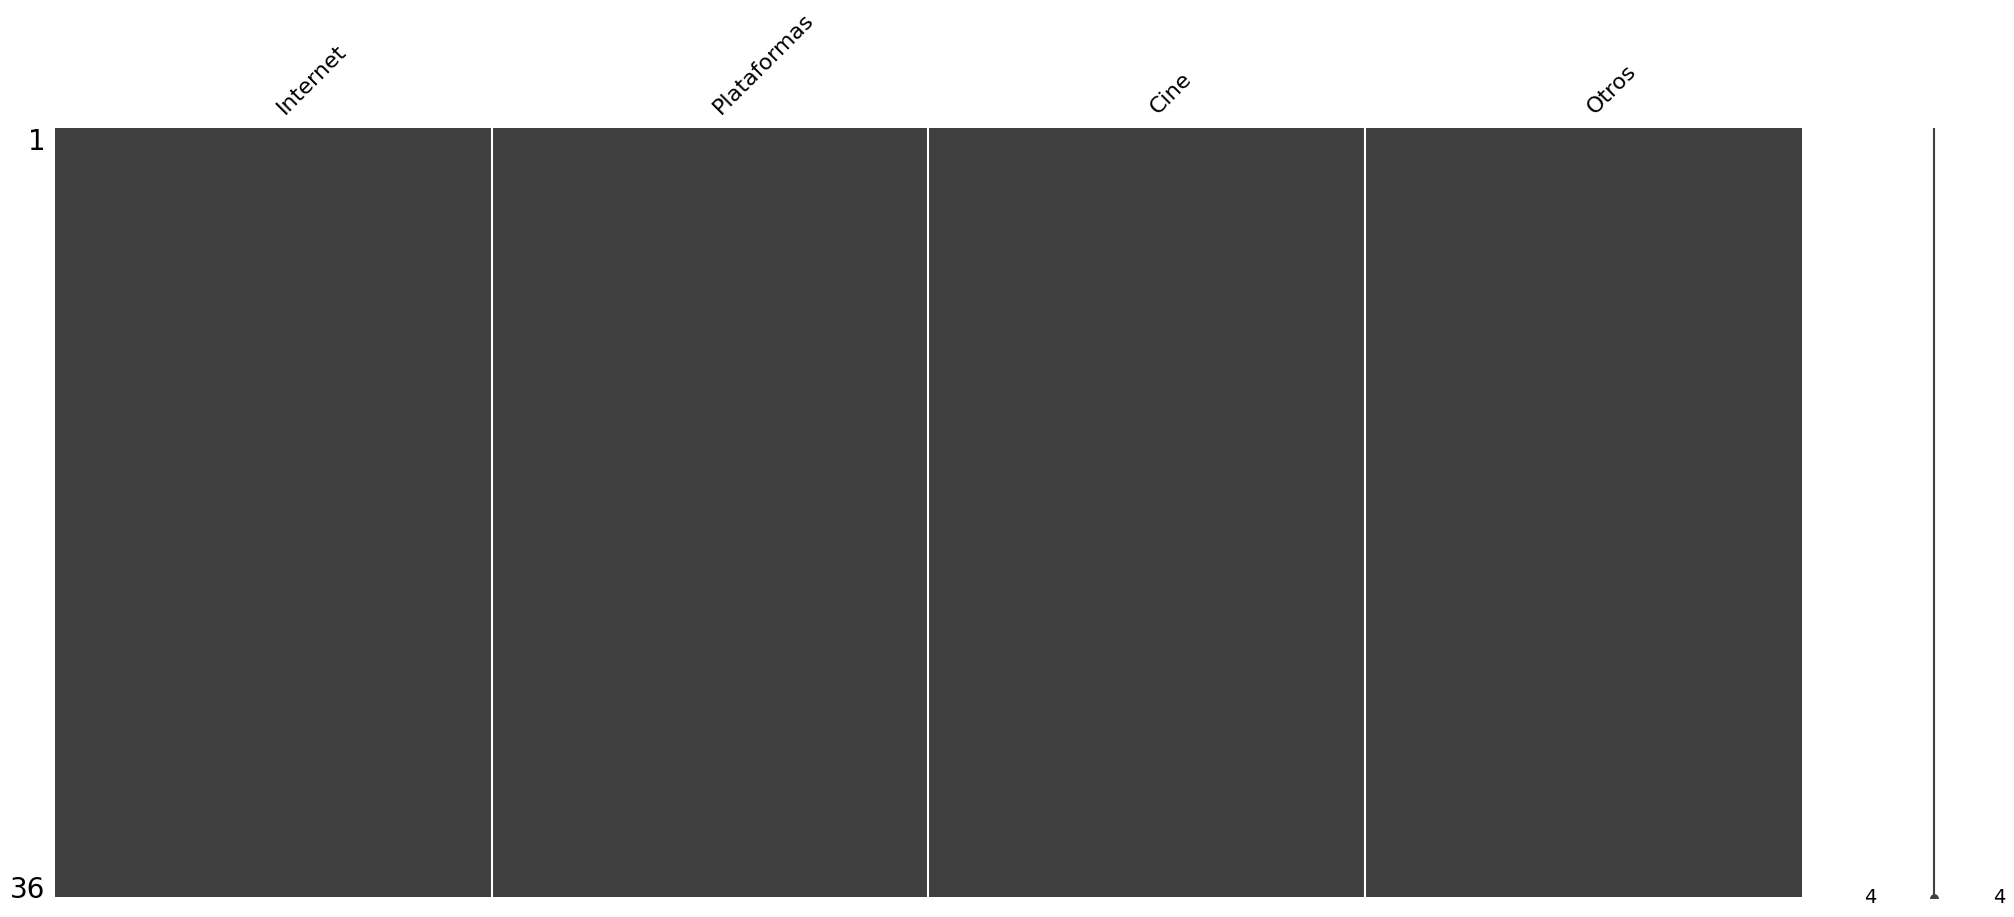

In [41]:
msno.matrix(df_inv)

In [43]:
# ---------------------------
# 3. Prepare Outcome Variables
# ---------------------------
# Resample outcome variables to monthly sums
df_visit_store_m = df_visit_store.resample('M').sum().rename(columns={'value': 'Visit_Store'})
df_sales_m       = df_sales.resample('M').sum().rename(columns={'value': 'Sales'})
df_unique_m      = df_unique.resample('M').sum().rename(columns={'value': 'Unique_visitors'})

# Create Traffic/Sales Ratio (Unique_visitors / Sales); handle division by zero
df_ratio = df_unique_m.copy()
df_ratio['TrafficSalesRatio'] = df_unique_m['Unique_visitors'] / df_sales_m['Sales']
df_ratio['TrafficSalesRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_ratio['TrafficSalesRatio'].fillna(0, inplace=True)

# Merge outcomes into a single DataFrame
df_outcomes = df_visit_store_m.merge(df_sales_m, left_index=True, right_index=True)\
                              .merge(df_ratio[['TrafficSalesRatio']], left_index=True, right_index=True)
print("\nOutcome Data (monthly):")
print(df_outcomes.head())


Outcome Data (monthly):
            Visit_Store  Sales  TrafficSalesRatio
timestamp                                        
2022-01-31         5516   1299         209.685912
2022-02-28         6769   1752         201.244863
2022-03-31         6249   1897         175.516605
2022-04-30         6507   1546         182.515524
2022-05-31         7183   1784         146.765135


/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_97739/1214858893.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_visit_store_m = df_visit_store.resample('M').sum().rename(columns={'value': 'Visit_Store'})
/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_97739/1214858893.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_sales_m       = df_sales.resample('M').sum().rename(columns={'value': 'Sales'})
/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_97739/1214858893.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_unique_m      = df_unique.resample('M').sum().rename(columns={'value': 'Unique_visitors'})
/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_97739/1214858893.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained as

<Axes: >

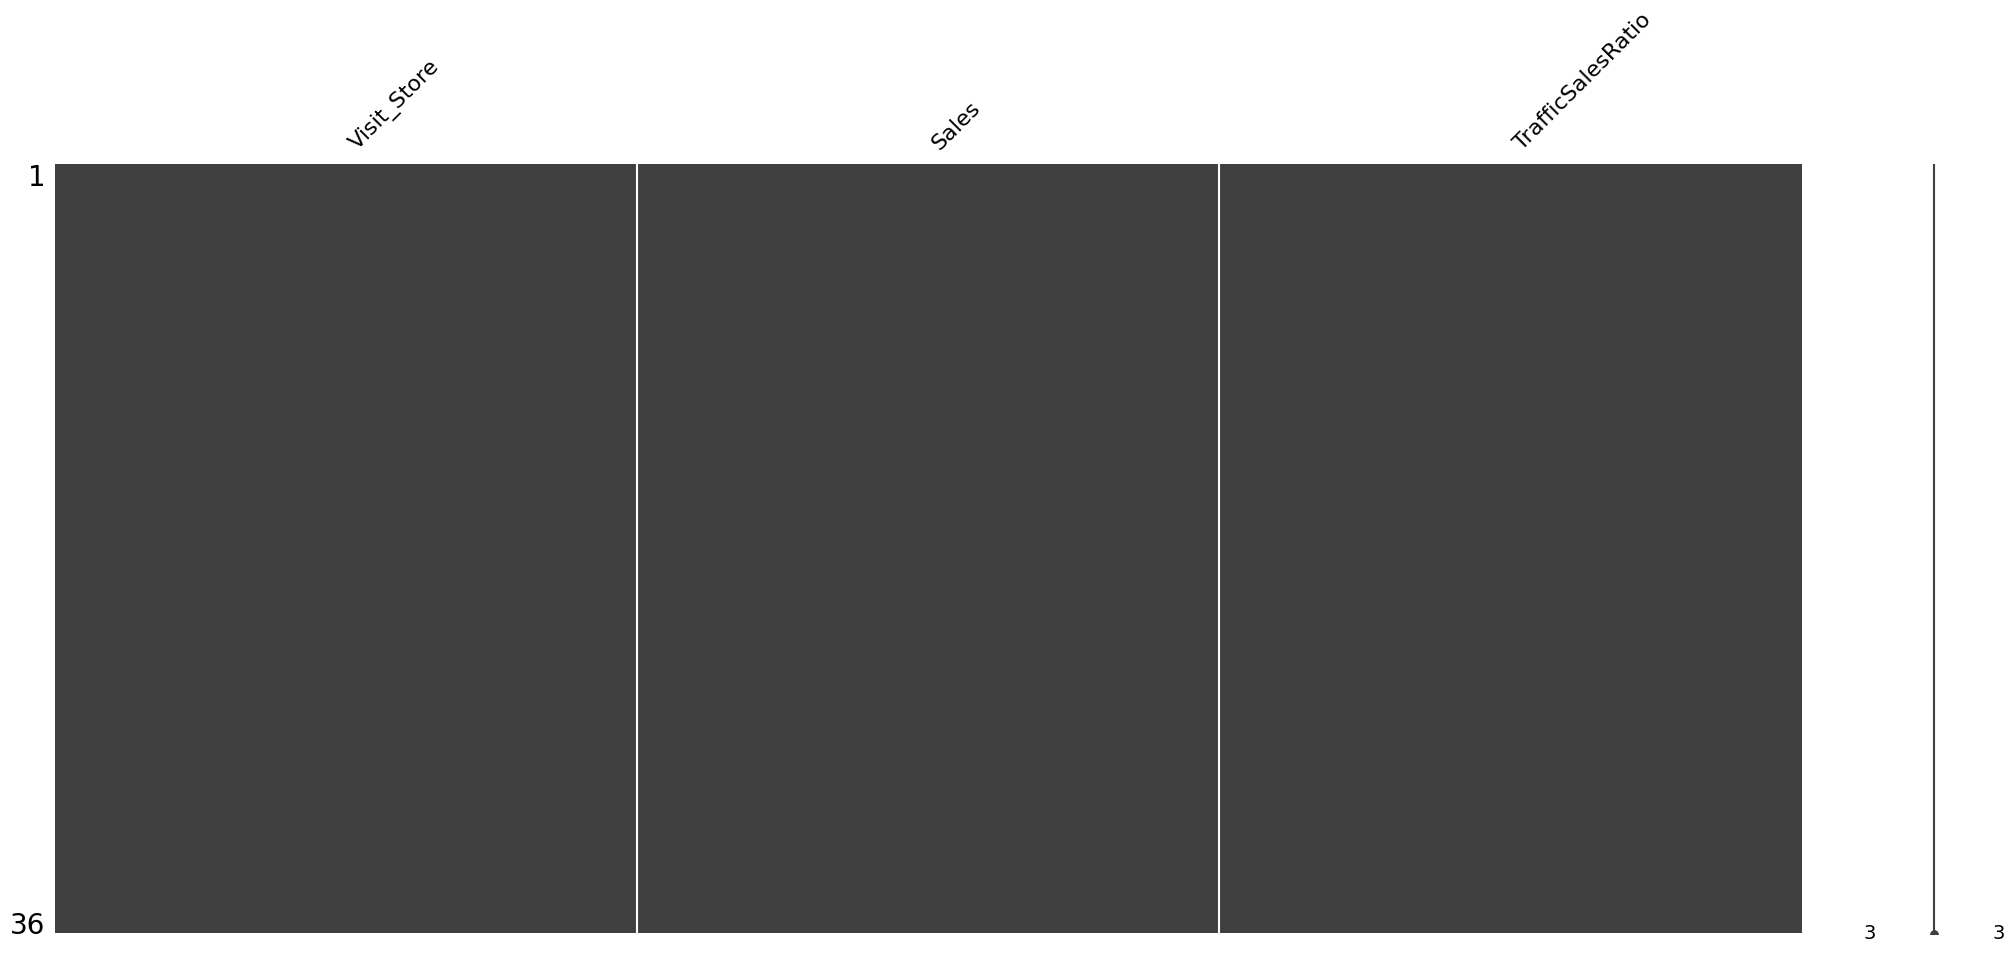

In [44]:
msno.matrix(df_outcomes)

In [46]:
# ---------------------------
# 5. Build Attribution Models (Without Log Transformation)
# ---------------------------
# We test three target variables: Visit_Store, Sales, and TrafficSalesRatio.
# For Sales and TrafficSalesRatio, we add the previous month's Unique_visitors as an extra predictor.
targets = ['Visit_Store', 'Sales', 'TrafficSalesRatio']
results_nolog = {}

for target in targets:
    # Use predictors from lagged investments
    X = df_model[['Internet', 'Plataformas', 'Cine', 'Otros']].copy()
    y = df_model[target].copy()
    
    # For Sales and TrafficSalesRatio, add lagged Unique_visitors as an extra predictor
    if target in ['Sales', 'TrafficSalesRatio']:
        df_unique_lag = df_unique_m.shift(1)
        X_extra = X.merge(df_unique_lag.rename(columns={'Unique_visitors': 'Unique_visitors'}), 
                          left_index=True, right_index=True, how='left')
        X_extra = X_extra.dropna()
        y = y.loc[X_extra.index]
        X_used = X_extra
        t_index = X_extra.index
    else:
        X_used = X
        t_index = df_model.index
    
    # Fit Ridge regression with cross-validation
    alphas = np.logspace(-3, 3, 100)
    ridge_cv = RidgeCV(alphas=alphas, cv=5)
    ridge_cv.fit(X_used, y)
    
    # Predict and calculate performance metrics
    y_pred = ridge_cv.predict(X_used)
    mse = mean_squared_error(y, y_pred)
    r2  = r2_score(y, y_pred)
    
    results_nolog[target] = {
        'model': ridge_cv,
        'mse': mse,
        'r2': r2,
        'coefficients': dict(zip(X_used.columns, ridge_cv.coef_)),
        'best_alpha': ridge_cv.alpha_,
        'y_pred': y_pred,
        'y_true': y,
        't_index': t_index,
        'X_used': X_used
    }
    
    print(f"\nTarget: {target}")
    print("MSE:", mse)
    print("R²:", r2)
    print("Best alpha:", ridge_cv.alpha_)
    print("Coefficients:")
    for feat, coef in results_nolog[target]['coefficients'].items():
        print(f"  {feat}: {coef:.4f}")


Target: Visit_Store
MSE: 358516.34555883176
R²: 0.14511901948792583
Best alpha: 1000.0
Coefficients:
  Internet: 0.0020
  Plataformas: 0.0004
  Cine: -0.0089
  Otros: -0.0002

Target: Sales
MSE: 74096.17912726056
R²: 0.08143636736248716
Best alpha: 1000.0
Coefficients:
  Internet: 0.0007
  Plataformas: 0.0002
  Cine: -0.0019
  Otros: -0.0007
  Unique_visitors: 0.0002

Target: TrafficSalesRatio
MSE: 1145.997125748438
R²: 0.12077584152134968
Best alpha: 1000.0
Coefficients:
  Internet: -0.0001
  Plataformas: -0.0000
  Cine: 0.0001
  Otros: 0.0000
  Unique_visitors: 0.0002


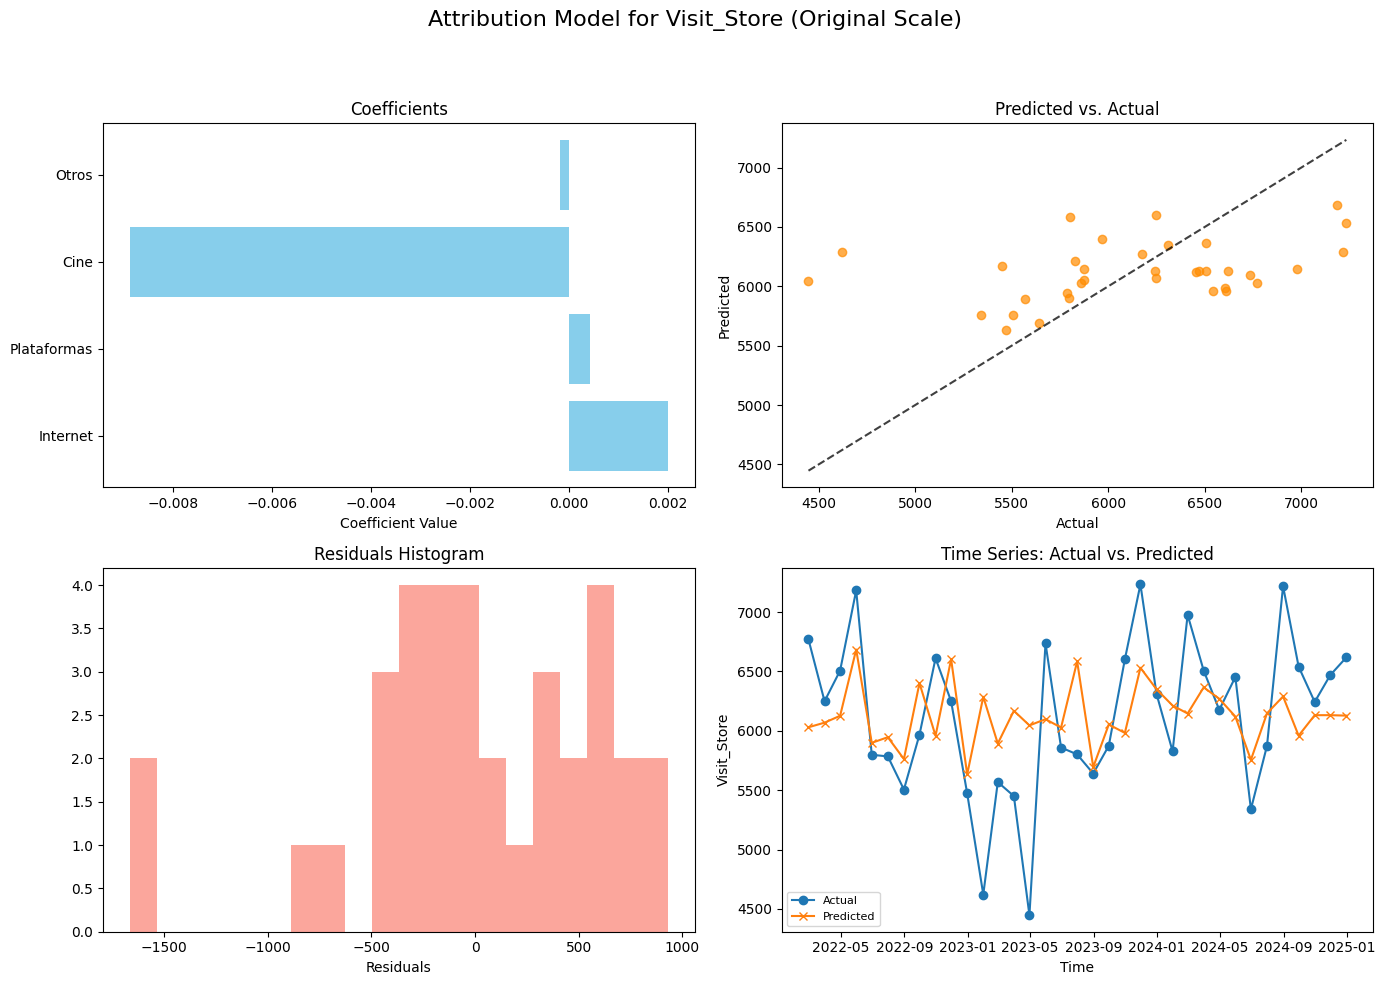

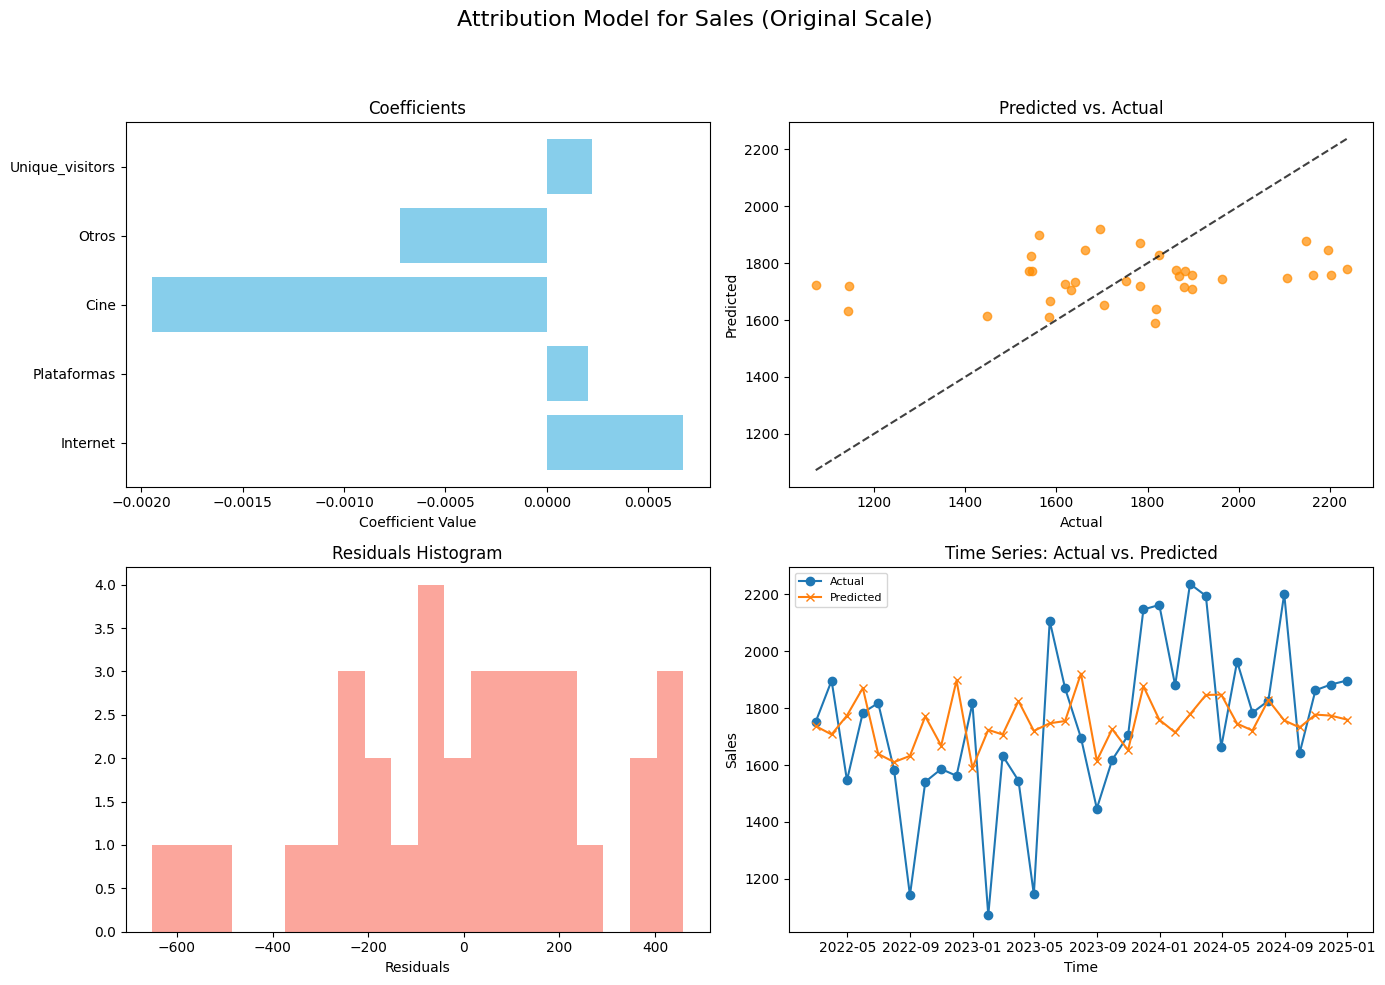

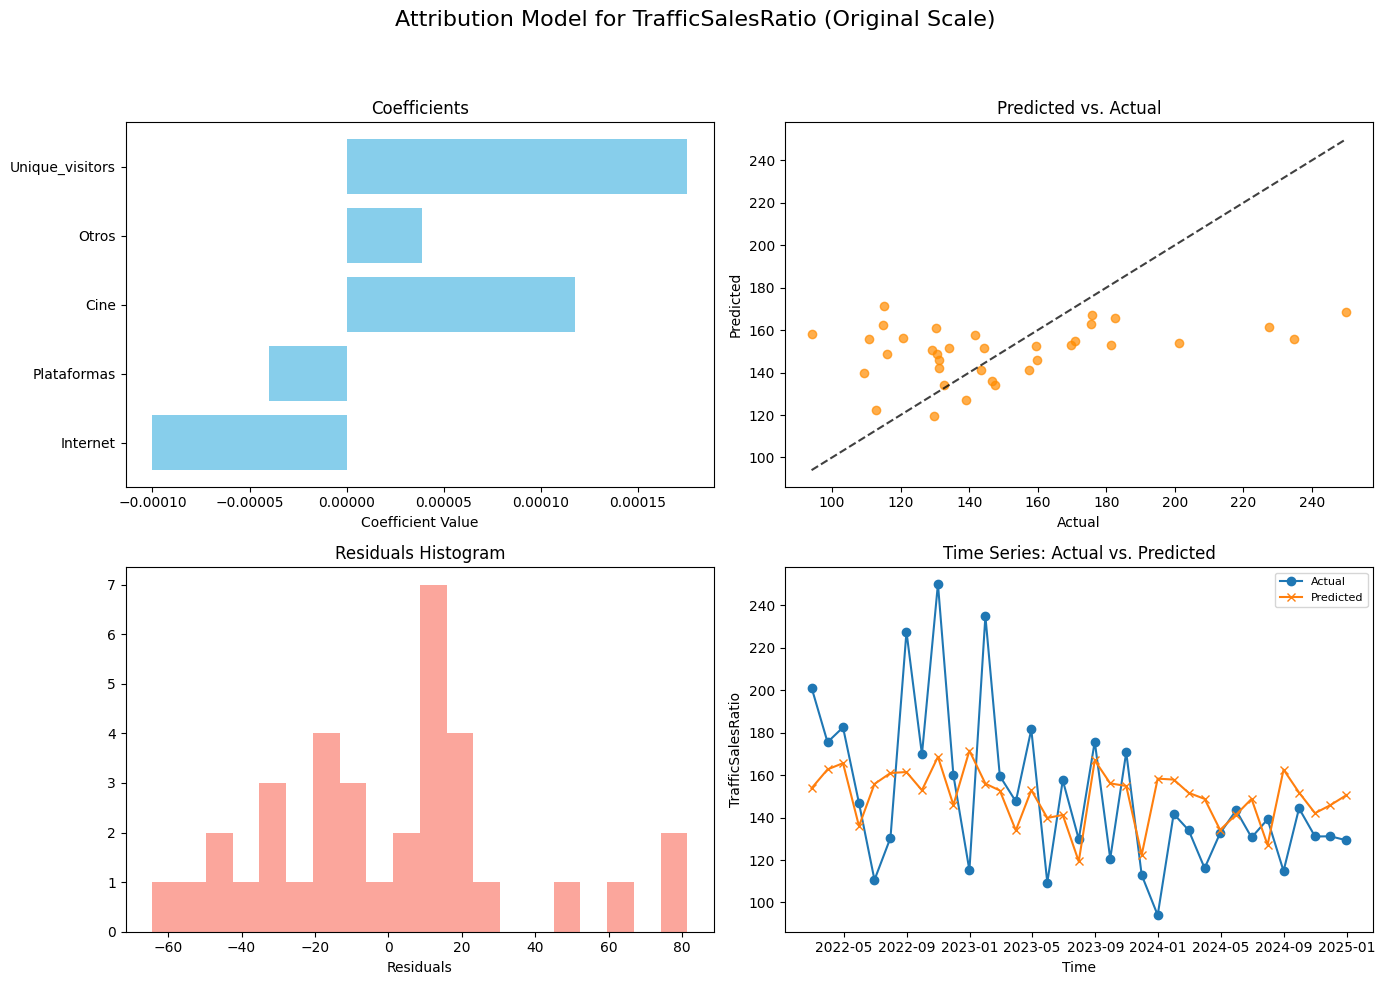

In [47]:
# ---------------------------
# 6. Visualize the Results (Without Log Transformation)
# ---------------------------
# Prepare containers for predictions and residuals per target.
predictions_dict = {}
residuals_dict = {}
time_indices = {}

for target in targets:
    res = results_nolog[target]
    predictions_dict[target] = res['y_pred']
    residuals_dict[target] = res['y_true'] - res['y_pred']
    time_indices[target] = res['t_index']

# For each target, create a 2x2 grid of plots.
for target in targets:
    fig, axs = plt.subplots(2, 2, figsize=(14,10))
    fig.suptitle(f"Attribution Model for {target} (Original Scale)", fontsize=16)
    
    # Plot 1: Horizontal bar chart of coefficients.
    coefs = results_nolog[target]['coefficients']
    feat_names = list(coefs.keys())
    coef_values = [coefs[name] for name in feat_names]
    axs[0,0].barh(feat_names, coef_values, color='skyblue')
    axs[0,0].set_title("Coefficients")
    axs[0,0].set_xlabel("Coefficient Value")
    
    # Plot 2: Scatter plot of Actual vs. Predicted.
    y_true = results_nolog[target]['y_true']
    y_pred = results_nolog[target]['y_pred']
    axs[0,1].scatter(y_true, y_pred, color='darkorange', alpha=0.7)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    axs[0,1].plot(lims, lims, 'k--', alpha=0.75)
    axs[0,1].set_xlabel("Actual")
    axs[0,1].set_ylabel("Predicted")
    axs[0,1].set_title("Predicted vs. Actual")
    
    # Plot 3: Histogram of Residuals.
    axs[1,0].hist(residuals_dict[target], bins=20, color='salmon', alpha=0.7)
    axs[1,0].set_xlabel("Residuals")
    axs[1,0].set_title("Residuals Histogram")
    
    # Plot 4: Time series plot: Actual vs. Predicted.
    axs[1,1].plot(time_indices[target], y_true, label='Actual', marker='o')
    axs[1,1].plot(time_indices[target], y_pred, label='Predicted', marker='x')
    axs[1,1].set_xlabel("Time")
    axs[1,1].set_ylabel(target)
    axs[1,1].set_title("Time Series: Actual vs. Predicted")
    axs[1,1].legend(fontsize=8)
    
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

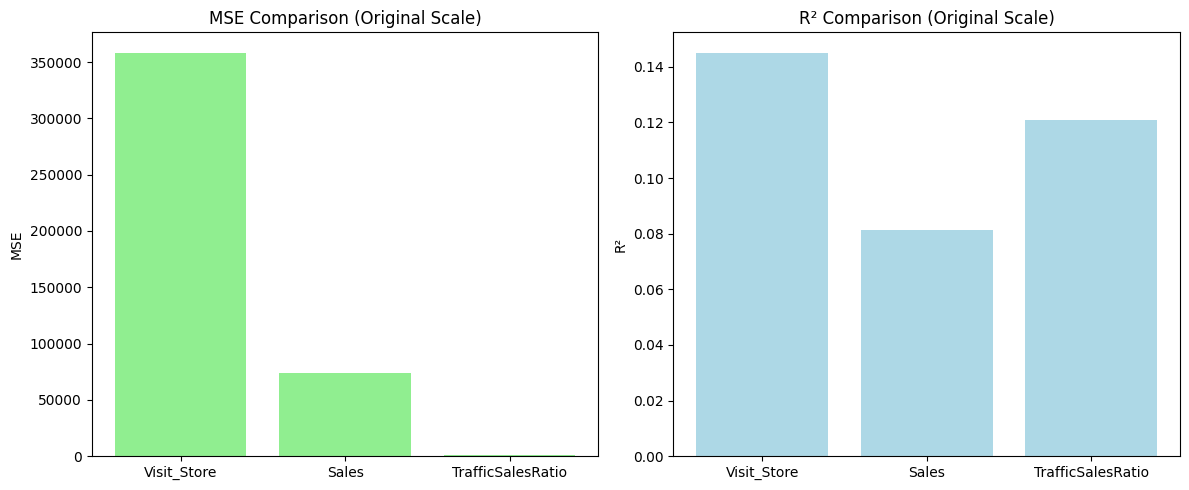

In [48]:

# Overall Comparison: Create a separate plot comparing MSE and R² across targets.
target_names = list(results_nolog.keys())
mse_values = [results_nolog[t]['mse'] for t in target_names]
r2_values  = [results_nolog[t]['r2'] for t in target_names]

fig2, axs2 = plt.subplots(1, 2, figsize=(12,5))
axs2[0].bar(target_names, mse_values, color='lightgreen')
axs2[0].set_title("MSE Comparison (Original Scale)")
axs2[0].set_ylabel("MSE")
axs2[1].bar(target_names, r2_values, color='lightblue')
axs2[1].set_title("R² Comparison (Original Scale)")
axs2[1].set_ylabel("R²")
plt.tight_layout()
plt.show()

/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_97739/1952497552.py:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_97739/1952497552.py:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_97739/1952497552.py:6: FutureWarning: The behavio

Grouped Investment Data (monthly):
             Internet  Plataformas      Cine      Otros
timestamp                                              
2022-01-31  133666.43    338824.94  59887.84   42220.93
2022-02-28  189275.94    487537.14  72291.56  167410.44
2022-03-31  214037.62     75000.00  55000.00   23484.85
2022-04-30  194816.97    610865.89  10883.30  124621.75
2022-05-31  130795.16    393807.74  74333.20  147454.07

Extended Design Matrix (first 5 rows):
             Internet  Plataformas      Cine      Otros  Visit_Store_Lag1  \
timestamp                                                                   
2022-02-28  133666.43    338824.94  59887.84   42220.93            5516.0   
2022-03-31  189275.94    487537.14  72291.56  167410.44            6769.0   
2022-04-30  214037.62     75000.00  55000.00   23484.85            6249.0   
2022-05-31  194816.97    610865.89  10883.30  124621.75            6507.0   
2022-06-30  130795.16    393807.74  74333.20  147454.07            7183

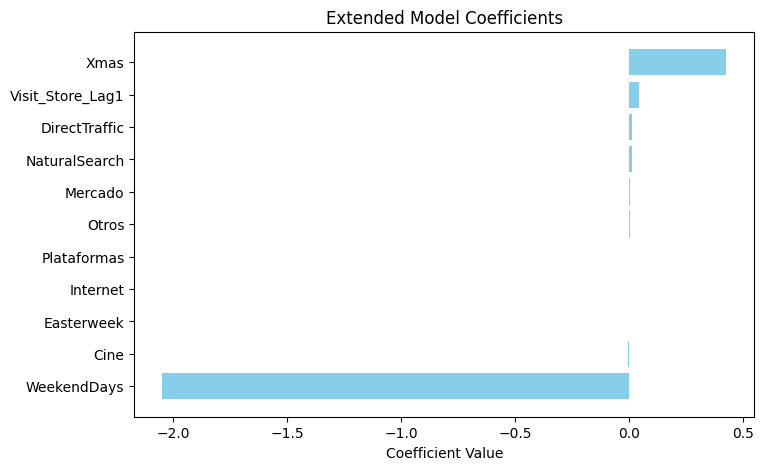

In [51]:
df_cine         = dict_to_df(data["CINE"])
df_exterior     = dict_to_df(data["EXTERIOR"])
df_internet     = dict_to_df(data["INTERNET"])
df_prensa       = dict_to_df(data["PRENSA"])
df_produccion   = dict_to_df(data["PRODUCCION"])
df_radio        = dict_to_df(data["RADIO"])
df_revistas     = dict_to_df(data["REVISTAS"])
df_plataformas  = dict_to_df(data["PlataformasVideo"])
df_varios       = dict_to_df(data["VARIOS"])
df_visit_store  = dict_to_df(data["Visit_Store"])
df_sales        = dict_to_df(data["Sales"])
df_unique       = dict_to_df(data["Unique_visitors"])

# --- Additional Variables (we now load them explicitly) ---
df_mercado            = dict_to_df(data["Mercado"])
df_naturalsearch      = dict_to_df(data["NaturalSearch"])
df_directtraffic      = dict_to_df(data["DirectTraffic"])
df_easterweek         = dict_to_df(data["Easterweek"])
df_dias_fines_semana  = dict_to_df(data["Dias_fines_semana"])

# ================================
# 2. Group the Investment Variables into 4 Channels
# ================================

# Group "Otros": sum of EXTERIOR, PRENSA, RADIO, REVISTAS, PRODUCCION, VARIOS
dfs_otros = [
    df_exterior.rename(columns={'value': 'EXTERIOR'}),
    df_prensa.rename(columns={'value': 'PRENSA'}),
    df_radio.rename(columns={'value': 'RADIO'}),
    df_revistas.rename(columns={'value': 'REVISTAS'}),
    df_produccion.rename(columns={'value': 'PRODUCCION'}),
    df_varios.rename(columns={'value': 'VARIOS'})
]
df_otros = pd.concat(dfs_otros, axis=1).fillna(0)
df_otros['Otros'] = df_otros.sum(axis=1)

# Resample all series to monthly frequency (using sum)
df_internet_m    = df_internet.resample('M').sum().rename(columns={'value': 'Internet'})
df_plataformas_m = df_plataformas.resample('M').sum().rename(columns={'value': 'Plataformas'})
df_cine_m        = df_cine.resample('M').sum().rename(columns={'value': 'Cine'})
df_otros_m       = df_otros.resample('M').sum()[['Otros']]

# Merge grouped investments into one DataFrame
df_inv = pd.concat([df_internet_m, df_plataformas_m, df_cine_m, df_otros_m], axis=1)
print("Grouped Investment Data (monthly):")
print(df_inv.head())

# ================================
# 3. Prepare Outcome Variables and Extra Predictors
# ================================

# Resample outcomes to monthly sums
df_visit_store_m = df_visit_store.resample('M').sum().rename(columns={'value': 'Visit_Store'})
df_sales_m       = df_sales.resample('M').sum().rename(columns={'value': 'Sales'})
df_unique_m      = df_unique.resample('M').sum().rename(columns={'value': 'Unique_visitors'})

# Compute Traffic/Sales Ratio (if needed later)
df_ratio = df_unique_m.copy()
df_ratio['TrafficSalesRatio'] = df_unique_m['Unique_visitors'] / df_sales_m['Sales']
df_ratio['TrafficSalesRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_ratio['TrafficSalesRatio'].fillna(0, inplace=True)

# Extra predictors: resample to monthly
df_mercado_m       = df_mercado.resample('M').sum().rename(columns={'value': 'Mercado'})
df_naturalsearch_m = df_naturalsearch.resample('M').sum().rename(columns={'value': 'NaturalSearch'})
df_directtraffic_m = df_directtraffic.resample('M').sum().rename(columns={'value': 'DirectTraffic'})
# Easterweek: if binary (0/1) use mean (or sum if counts are desired)
df_easterweek_m    = df_easterweek.resample('M').mean().rename(columns={'value': 'Easterweek'})
# Weekend indicator: use Dias_fines_semana (number of weekend days in the month)
df_weekend_m       = df_dias_fines_semana.resample('M').sum().rename(columns={'value': 'WeekendDays'})

# Create Xmas dummy: 1 if month is December, else 0
df_xmas = pd.DataFrame(index=df_inv.index)
df_xmas['Xmas'] = (df_xmas.index.month == 12).astype(int)

# ================================
# 4. Build the Extended Design Matrix
# ================================
# Apply a one-period lag (t-1) to the advertising investments
df_inv_lag = df_inv.shift(1)

# Also, include a lagged outcome: Visit_Store at t-1
df_visit_store_lag = df_visit_store_m.shift(1).rename(columns={'Visit_Store': 'Visit_Store_Lag1'})

# Merge all predictors into one design matrix using the monthly index
df_design = df_inv_lag.copy()  # Contains: Internet, Plataformas, Cine, Otros (lagged)
df_design = df_design.merge(df_visit_store_lag, left_index=True, right_index=True, how='left')
df_design = df_design.merge(df_mercado_m, left_index=True, right_index=True, how='left')
df_design = df_design.merge(df_naturalsearch_m, left_index=True, right_index=True, how='left')
df_design = df_design.merge(df_directtraffic_m, left_index=True, right_index=True, how='left')
df_design = df_design.merge(df_easterweek_m, left_index=True, right_index=True, how='left')
df_design = df_design.merge(df_weekend_m, left_index=True, right_index=True, how='left')
df_design = df_design.merge(df_xmas, left_index=True, right_index=True, how='left')

# The outcome remains the current month's Visit_Store
df_outcome = df_visit_store_m.copy()

# Merge design matrix with outcome; drop rows with missing data (due to lags)
df_model_ext = df_design.merge(df_outcome, left_index=True, right_index=True, how='inner').dropna()
print("\nExtended Design Matrix (first 5 rows):")
print(df_model_ext.head())

# ================================
# 5. Fit the Extended Attribution Model
# ================================
# In this example, our target (Yₜ) is Visit_Store.
# Our predictors include:
#    - Lagged investments: Internet, Plataformas, Cine, Otros
#    - Lagged outcome: Visit_Store_Lag1
#    - Extra variables: Mercado, NaturalSearch, DirectTraffic, Easterweek, WeekendDays, Xmas
X_ext = df_model_ext.drop(columns=['Visit_Store'])
y_ext = df_model_ext['Visit_Store']

# Fit Ridge regression with cross-validation
alphas = np.logspace(-3, 3, 100)
ridge_cv_ext = RidgeCV(alphas=alphas, cv=5)
ridge_cv_ext.fit(X_ext, y_ext)

# Predictions and performance
y_pred_ext = ridge_cv_ext.predict(X_ext)
mse_ext = mean_squared_error(y_ext, y_pred_ext)
r2_ext  = r2_score(y_ext, y_pred_ext)

print("\nExtended Model Performance (Predicting Visit_Store):")
print("MSE:", mse_ext)
print("R²:", r2_ext)
print("Best alpha:", ridge_cv_ext.alpha_)
print("Coefficients:")
for feat, coef in zip(X_ext.columns, ridge_cv_ext.coef_):
    print(f"  {feat}: {coef:.4f}")

# Optional: Visualize coefficients
coef_df = pd.DataFrame({'Feature': X_ext.columns, 'Coefficient': ridge_cv_ext.coef_})
coef_df = coef_df.sort_values('Coefficient')
plt.figure(figsize=(8,5))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.xlabel("Coefficient Value")
plt.title("Extended Model Coefficients")
plt.show()

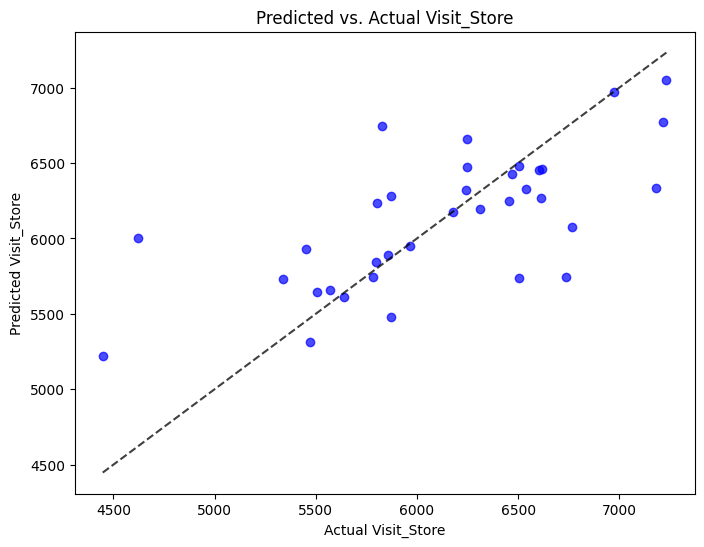

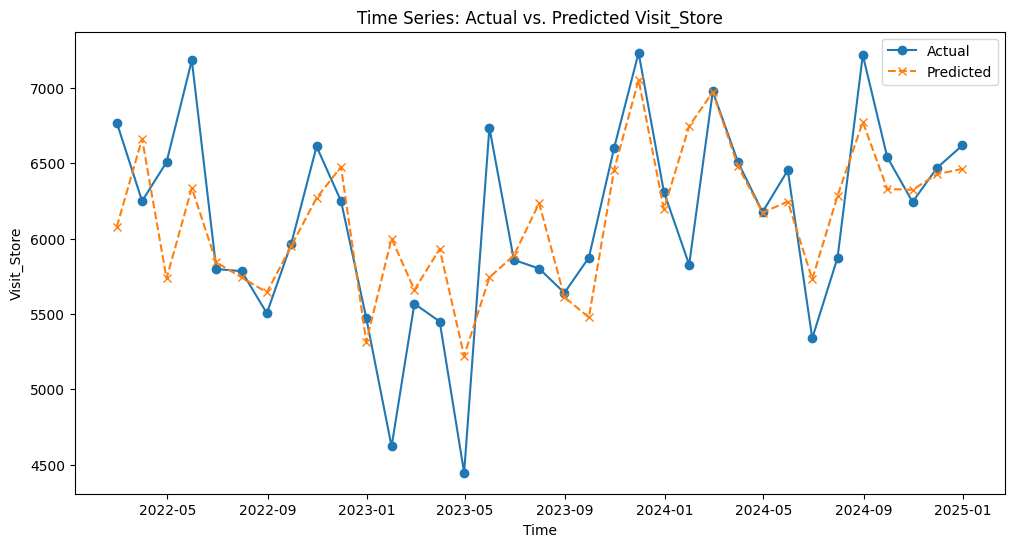

In [55]:
# --- Predicted vs. Actual Scatter Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(y_ext, y_pred_ext, color='blue', alpha=0.7)
# Plot the 45-degree reference line
lims = [min(y_ext.min(), y_pred_ext.min()), max(y_ext.max(), y_pred_ext.max())]
plt.plot(lims, lims, 'k--', alpha=0.75)
plt.xlabel("Actual Visit_Store")
plt.ylabel("Predicted Visit_Store")
plt.title("Predicted vs. Actual Visit_Store")
plt.show()

# --- Time Series Plot: Actual vs. Predicted ---
plt.figure(figsize=(12, 6))
plt.plot(df_model_ext.index, y_ext, label='Actual', marker='o', linestyle='-')
plt.plot(df_model_ext.index, y_pred_ext, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Visit_Store")
plt.title("Time Series: Actual vs. Predicted Visit_Store")
plt.legend()
plt.show()

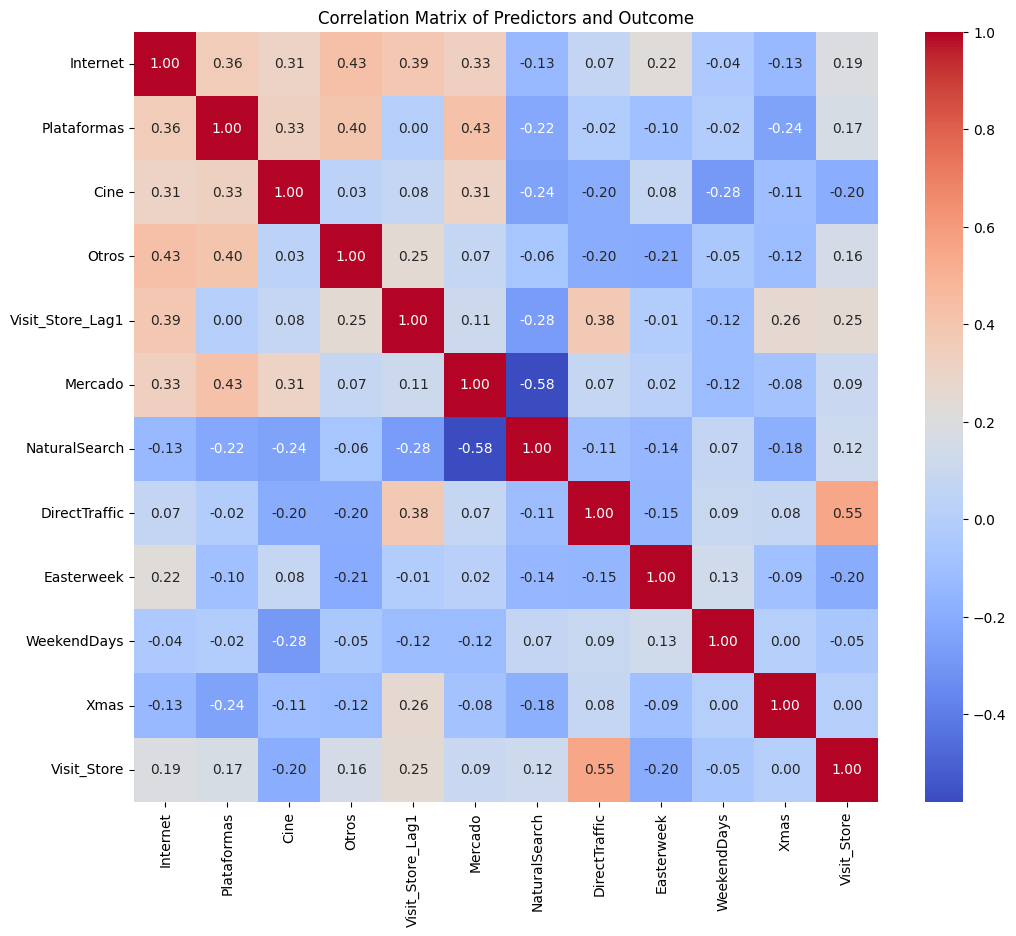

In [52]:
import seaborn as sns

# Select a set of variables from your extended design matrix plus the outcome.
# Adjust the list as needed.
cols_to_plot = ['Internet', 'Plataformas', 'Cine', 'Otros', 'Visit_Store_Lag1',
                'Mercado', 'NaturalSearch', 'DirectTraffic', 'Easterweek', 'WeekendDays', 'Xmas', 'Visit_Store']
df_corr = df_model_ext[cols_to_plot].corr()

plt.figure(figsize=(12,10))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Predictors and Outcome")
plt.show()

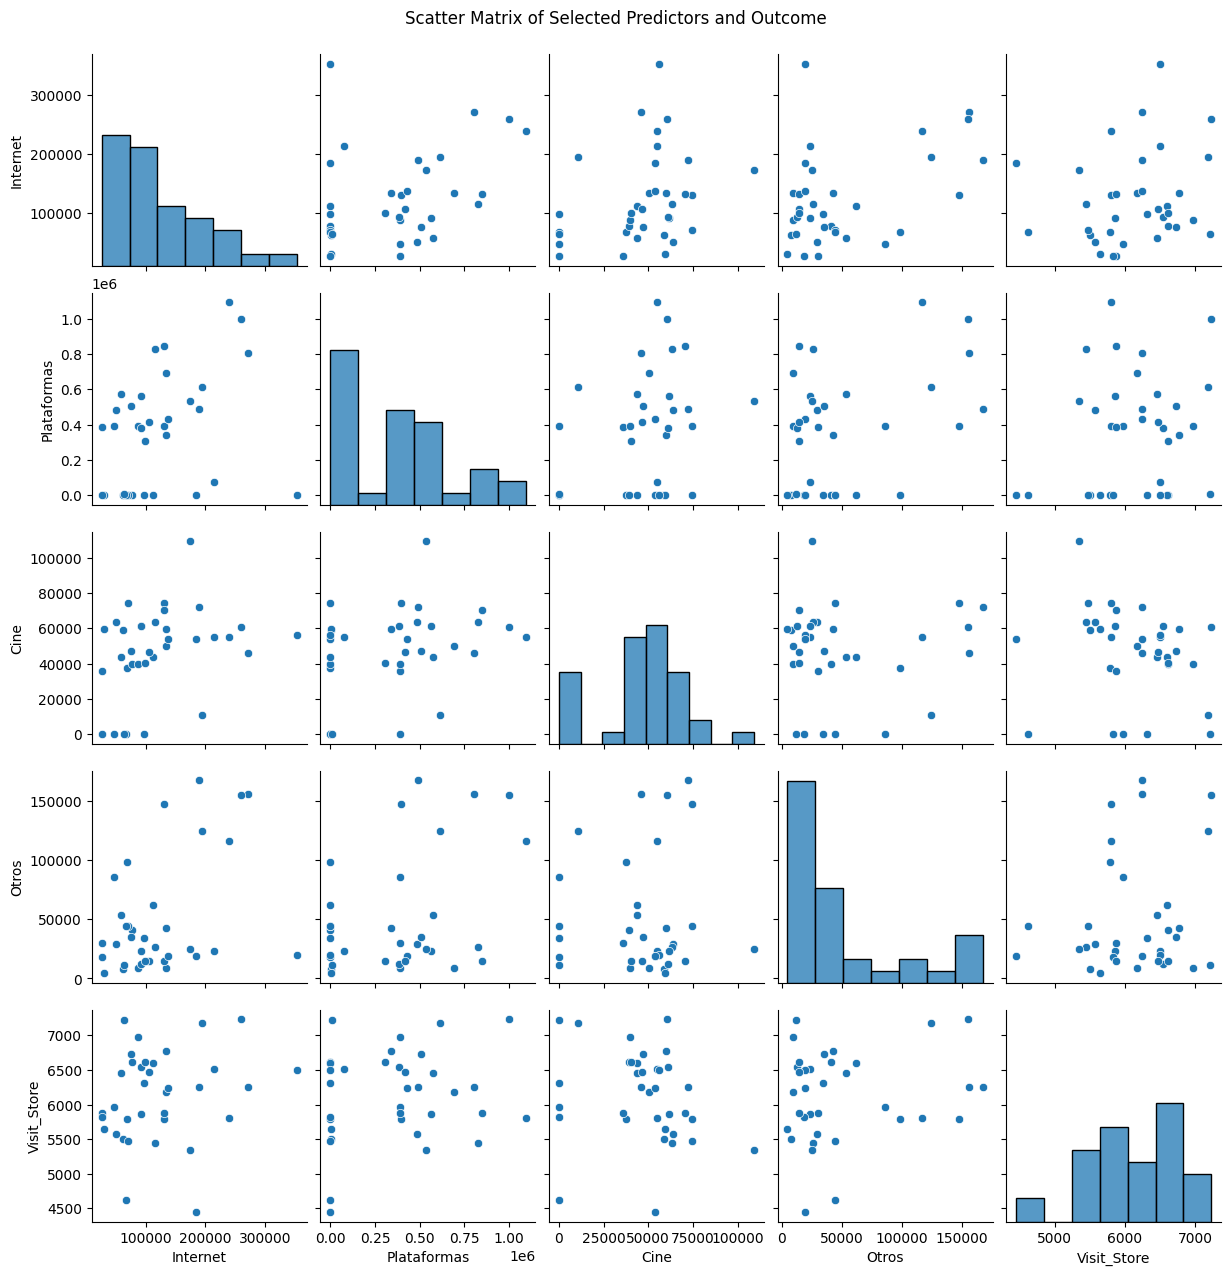

In [53]:
sns.pairplot(df_model_ext[['Internet', 'Plataformas', 'Cine', 'Otros', 'Visit_Store']])
plt.suptitle("Scatter Matrix of Selected Predictors and Outcome", y=1.02)
plt.show()

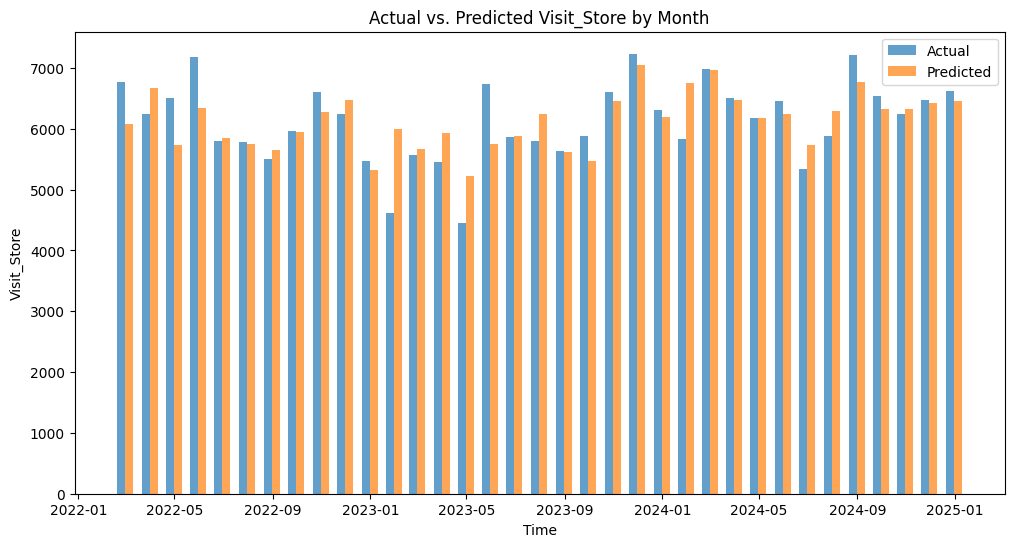

In [54]:
plt.figure(figsize=(12,6))
# Adjust positions for clarity
plt.bar(df_model_ext.index - pd.Timedelta(days=5), y_ext, width=10, label="Actual", alpha=0.7)
plt.bar(df_model_ext.index + pd.Timedelta(days=5), y_pred_ext, width=10, label="Predicted", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Visit_Store")
plt.title("Actual vs. Predicted Visit_Store by Month")
plt.legend()
plt.show()